In [1]:
import pandas as pd
import datetime
from pandas import Series, DataFrame

Read the CSV file containing finance data.

In [2]:
df = pd.read_csv('NVDA.csv')

In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2513,2019-09-09,179.899994,183.979996,179.839996,180.500000,180.500000,10438100
2514,2019-09-10,179.179993,184.250000,178.789993,183.179993,183.179993,8820300
2515,2019-09-11,183.770004,186.270004,182.600006,184.330002,184.330002,9037800
2516,2019-09-12,186.199997,188.399994,183.949997,184.270004,184.270004,8196000
2517,2019-09-13,181.589996,183.080002,180.179993,181.940002,181.940002,8068900


Let's convert data frame index to a datetime index, so that index column can be eliminated.

In [4]:
# Convert Date column in string format to Date format.
df['Date']= pd.to_datetime(df['Date'])

df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-09-14,16.080000,16.209999,15.910000,16.049999,14.791827,12262900
2009-09-15,16.200001,16.580000,16.049999,16.379999,15.095963,13653400
2009-09-16,16.340000,16.370001,15.700000,15.940000,14.690453,17676600
2009-09-17,15.900000,15.900000,14.970000,15.240000,14.045328,23077400
2009-09-18,15.390000,15.500000,15.100000,15.220000,14.026894,15118500


Get the dimension of dataframe

In [5]:
df.shape

(2518, 6)

Checking the rolling mean of the stock

In [6]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail(10)

Date
2019-08-30    163.297447
2019-09-03    163.022235
2019-09-04    162.798511
2019-09-05    162.699854
2019-09-06    162.643284
2019-09-09    162.570189
2019-09-10    162.533074
2019-09-11    162.517339
2019-09-12    162.479349
2019-09-13    162.396106
Name: Adj Close, dtype: float64

In [7]:
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

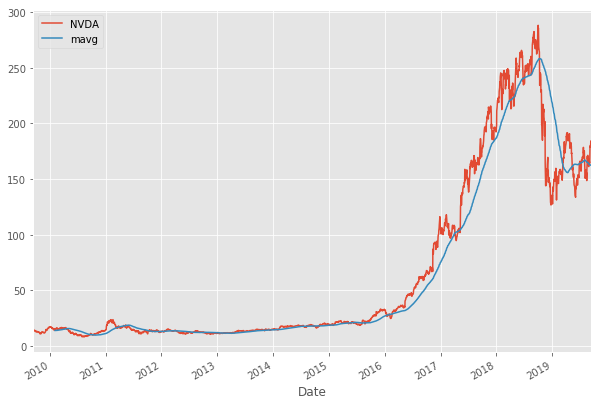

In [8]:
mpl.rc('figure', figsize=(10, 7))
style.use('ggplot')
close_px.plot(label='NVDA')
mavg.plot(label='mavg')
plt.legend()

Above plot shows that it mean average follows the trend and neglects the fluctuations. 


# Predicting the stocks price

Lets Prepare the data

In [9]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2009-09-14,14.791827,12262900,1.869153,-0.186573
2009-09-15,15.095963,13653400,3.235660,1.111099
2009-09-16,14.690453,17676600,4.203269,-2.447980
2009-09-17,14.045328,23077400,6.102362,-4.150943
2009-09-18,14.026894,15118500,2.628121,-1.104613


In [10]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
dfreg.head()

(2518, 4)


,Adj Close,Volume,HL_PCT,PCT_change,label
Date,,,,,
2009-09-14,14.791827,12262900,1.869153,-0.186573,12.635262
2009-09-15,15.095963,13653400,3.235660,1.111099,12.331132
2009-09-16,14.690453,17676600,4.203269,-2.447980,12.414075
2009-09-17,14.045328,23077400,6.102362,-4.150943,12.119162
2009-09-18,14.026894,15118500,2.628121,-1.104613,11.962486


In [11]:
X = np.array(dfreg.drop(['label'], 1))
X.shape

(2518, 4)

In [12]:
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

Dimension of X (2492, 4)
Dimension of y (2492,)


In [13]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Predicting stocks using liners regression

In [14]:
from sklearn.linear_model import LinearRegression

# Linear regression
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train, y_train)


confidencelin_reg = lin_reg.score(X_test, y_test)

print("The linear regression confidence is ",confidencelin_reg)

The linear regression confidence is  0.9678309591472251


Predicting stocks using Quadratic Regression 2

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures


# Quadratic Regression 2
reg_poly2 = make_pipeline(PolynomialFeatures(2), Ridge())
reg_poly2.fit(X_train, y_train)

confidencepoly2 = reg_poly2.score(X_test,y_test)

print("The quadratic regression 2 confidence is ",confidencepoly2)

The quadratic regression 2 confidence is  0.9741901340431659


Predicting stocks using Ridge Regression

In [16]:
from sklearn.linear_model import Ridge


# Ridge Regression
linridge = Ridge(alpha=0.7)
linridge.fit(X_train, y_train)

confidenceridge = linridge.score(X_test,y_test)

print("The Ridge regression confidence is ",confidenceridge)

The Ridge regression confidence is  0.9678391540518066


Predicting stocks using Ridge Regression

In [17]:
from sklearn.linear_model import Lasso


# Lasso Regression
linlasso = Lasso(alpha=0.1)
linlasso.fit(X_train, y_train)

confidencelasso = linlasso.score(X_test,y_test)

print("The Ridge regression confidence is ",confidencelasso)

The Ridge regression confidence is  0.9679690179433994


From above models, Quadratic Regression 2 model seems performing best among all above for NVDA stocks.

Lets try to visualise it on training data and forecast data.

In [18]:
# Printing the forecast
forecast_set = reg_poly2.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set, confidencepoly2, forecast_out)

[164.5882814  160.75666003 159.42669028 155.01139857 157.85663153
 158.17927504 175.25770878 176.66923322 177.4197955  179.71023195
 178.69131894 163.83484974 175.12087641 163.41961485 166.77242152
 175.52385344 173.56414285 173.75401767 177.56361918 184.83505651
 185.29045152 187.29793876 185.68378367 190.75616468 188.28185117
 189.69432938] 0.9741901340431659 26


In [19]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

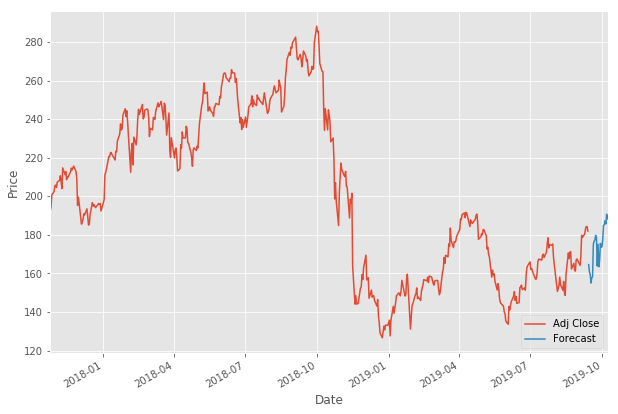

In [20]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()